Saving Cat.jpg to Cat (1).jpg


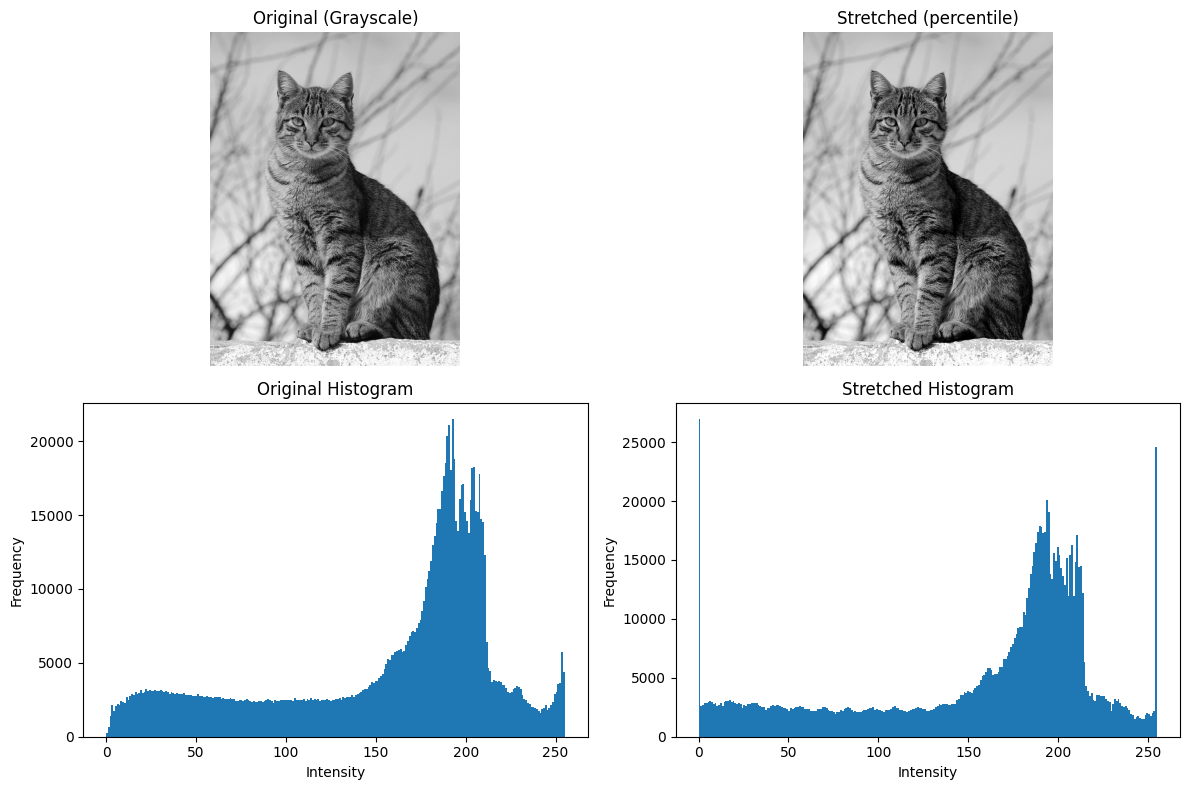

=== Original ===
Min: 0.00, Max: 255.00, Mean: 156.39, Std: 63.54

=== Min–Max Stretch mapping ===
[0.00, 255.00]  ->  [0, 255]

=== Percentile Stretch mapping (2%-98%) ===
[12.85, 248.37]  ->  [0, 255]


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Image loading  ---
img = '/content/Cat.jpg'
try:
    from google.colab import files
    uploaded = files.upload()  # pick any PNG/JPG
    import PIL.Image as Image
    import io
    fname = next(iter(uploaded))
    img = Image.open(io.BytesIO(uploaded[fname])).convert('RGB')
except Exception as e:
    # Fallback: generate a low-contrast synthetic image
    print("No upload detected; using a synthetic low-contrast image.")
    h, w = 256, 256
    base = np.linspace(80, 160, w, dtype=np.float32)
    img_np = np.tile(base, (h, 1))
    # Add a soft circle to create structure
    yy, xx = np.mgrid[0:h, 0:w]
    circle = ((xx - w/2)**2 + (yy - h/2)**2)**0.5
    circle = (circle - circle.min()) / (circle.max() - circle.min())
    img_np = (0.7*img_np + 30*circle).clip(0,255).astype(np.uint8)
    img = Image.fromarray(np.stack([img_np, img_np, img_np], axis=-1), mode='RGB')

# Convert to numpy and grayscale (we'll stretch grayscale to keep it simple "from scratch")
import PIL.Image as Image
img_rgb = np.array(img)
if img_rgb.ndim == 3:
    # Luma-like grayscale (no external libs)
    gray = (0.299*img_rgb[...,0] + 0.587*img_rgb[...,1] + 0.114*img_rgb[...,2]).astype(np.float32)
else:
    gray = img_rgb.astype(np.float32)

# --- 2) Contrast stretching functions (FROM SCRATCH) ---

def minmax_stretch(img_f32):
    """
    Linear contrast stretching: map [min, max] -> [0, 255].
    If min==max, return zeros to avoid divide-by-zero.
    """
    imin, imax = img_f32.min(), img_f32.max()
    if imax <= imin:
        return np.zeros_like(img_f32, dtype=np.uint8), (imin, imax)
    out = (img_f32 - imin) * (255.0 / (imax - imin))
    return out.clip(0,255).astype(np.uint8), (imin, imax)

def percentile_stretch(img_f32, low=2.0, high=98.0):
    """
    Robust linear stretch: map [p_low, p_high] -> [0, 255], clipping outside.
    Helps when there are a few extreme pixels.
    """
    p_low = np.percentile(img_f32, low)
    p_high = np.percentile(img_f32, high)
    if p_high <= p_low:
        return np.zeros_like(img_f32, dtype=np.uint8), (p_low, p_high)
    out = (img_f32 - p_low) * (255.0 / (p_high - p_low))
    out = np.clip(out, 0, 255)
    return out.astype(np.uint8), (p_low, p_high)

# --- 3) Run both stretches ---
stretched_minmax, (imin, imax) = minmax_stretch(gray)
stretched_pct, (p_low, p_high) = percentile_stretch(gray, 2, 98)

# Choose which to SHOW as the main "stretched" result:
show_variant = 'percentile'  # change to 'minmax' if you want
stretched = stretched_pct if show_variant=='percentile' else stretched_minmax

# --- 4) Display results + histograms ---
fig = plt.figure(figsize=(12, 8))

# Images
ax1 = plt.subplot(2,2,1)
ax1.imshow(gray.astype(np.uint8), cmap='gray', vmin=0, vmax=255)
ax1.set_title('Original (Grayscale)')
ax1.axis('off')

ax2 = plt.subplot(2,2,2)
ax2.imshow(stretched, cmap='gray', vmin=0, vmax=255)
ax2.set_title(f'Stretched ({show_variant})')
ax2.axis('off')

# Histograms
ax3 = plt.subplot(2,2,3)
ax3.hist(gray.flatten(), bins=256, range=(0,255))
ax3.set_title('Original Histogram')
ax3.set_xlabel('Intensity'); ax3.set_ylabel('Frequency')

ax4 = plt.subplot(2,2,4)
ax4.hist(stretched.flatten(), bins=256, range=(0,255))
ax4.set_title('Stretched Histogram')
ax4.set_xlabel('Intensity'); ax4.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# --- 5) Print stats ---
print("=== Original ===")
print(f"Min: {gray.min():.2f}, Max: {gray.max():.2f}, Mean: {gray.mean():.2f}, Std: {gray.std():.2f}")
print("\n=== Min–Max Stretch mapping ===")
print(f"[{imin:.2f}, {imax:.2f}]  ->  [0, 255]")
print("\n=== Percentile Stretch mapping (2%-98%) ===")
print(f"[{p_low:.2f}, {p_high:.2f}]  ->  [0, 255]")
